# Introduction
This project analyzes the housing prices, and builds machine learning models to predict the house price in California USA. The project is executed using Python3 language and other Python libraries.

# First look at the Data

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import joblib
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [2]:
housing = pd.read_csv('/opt/apps/ml-data/quant/housing/housing.csv')

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
'''
There is one categorical feature.
Take a look at the unique value counts.
'''
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

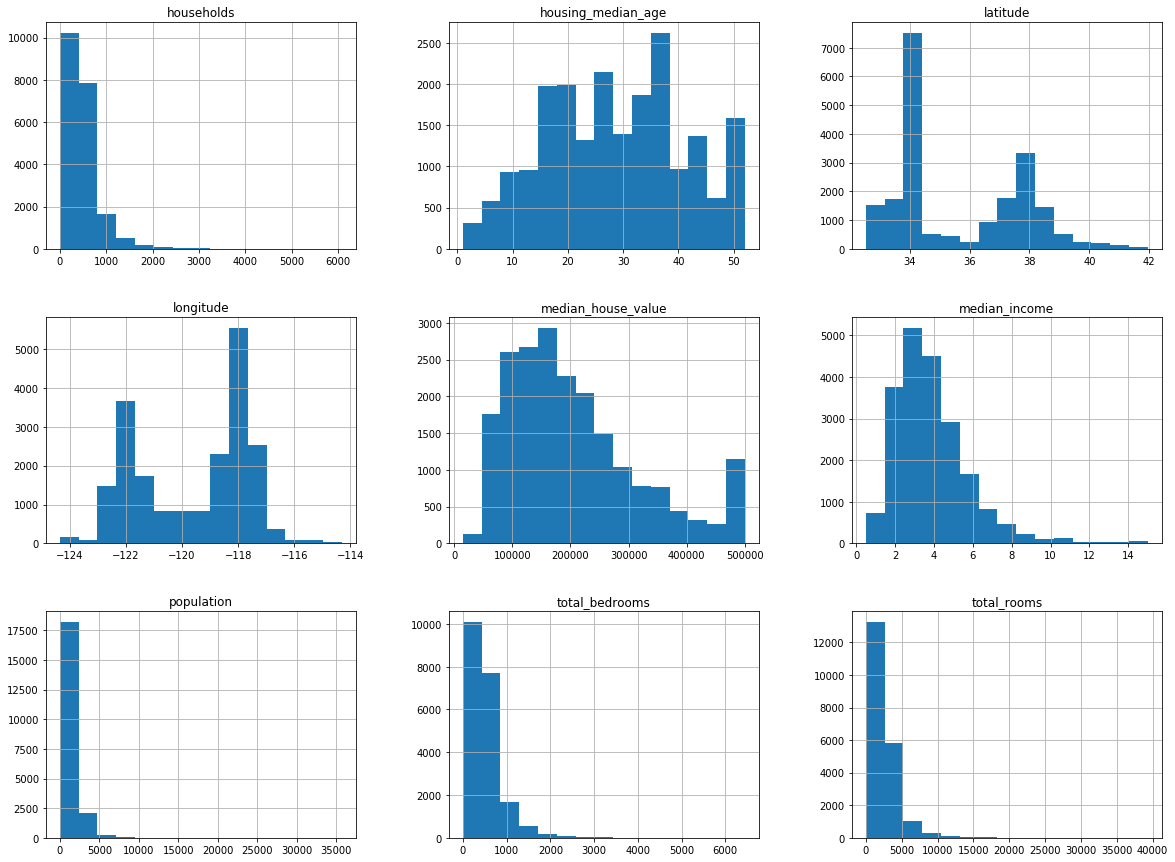

In [7]:
'''
Plot the distribution of nummerical values in a single view.
'''
housing.hist(bins=15, figsize=(20,15))
plt.show()

# Create the Training Set and Test Set

In [8]:
'''
Define a method to split the data using index but random permutation.
The training set will have 80% of the data and the test set will have 20% of the data.
Return the train set and test set.
'''
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
'''Split the data using random permutation'''
train_set, test_set = split_train_test(housing, 0.2)
print("Total records: ", housing.shape, "Train Set: ", train_set.shape, "Test Set: ", test_set.shape)

Total records:  (20640, 10) Train Set:  (16512, 10) Test Set:  (4128, 10)


In [10]:
'''
Define a method to split the data using hash of the index.
The training set will have 80% of the data and the test set will have 20% of the data.
Return the train set and test set.
'''
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio


def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [11]:
'''Split the data using hash of the index'''
housing_with_id = housing.reset_index()
# adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print("Total records: ", housing.shape, "Train Set: ", train_set.shape, "Test Set: ", test_set.shape)

Total records:  (20640, 10) Train Set:  (16362, 11) Test Set:  (4278, 11)


In [12]:
'''Split the data using hash of some unique columns'''
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print("Total records: ", housing.shape, "Train Set: ", train_set.shape, "Test Set: ", test_set.shape)

Total records:  (20640, 10) Train Set:  (16267, 12) Test Set:  (4373, 12)


In [13]:
'''Split the data using scikit-learn train_test_split'''
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print("Total records: ", housing.shape, "Train Set: ", train_set.shape, "Test Set: ", test_set.shape)

Total records:  (20640, 10) Train Set:  (16512, 10) Test Set:  (4128, 10)


In [14]:
'''Split the data using StratifiedShuffleSplit'''
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
housing["income_cat"].value_counts() / len(housing)

for set in (housing, strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)
    
    
print("Total records: ", housing.shape, "Train Set: ", strat_train_set.shape, "Test Set: ", strat_test_set.shape)

Total records:  (20640, 10) Train Set:  (16512, 10) Test Set:  (4128, 10)


# Exploratory Data Analysis

In [15]:
'''
All data vizualization can be done in the training set.
Create a copy of the training set, so that oriiginal data is not harmed.
'''
housing = strat_train_set.copy()
housing.shape

(16512, 10)

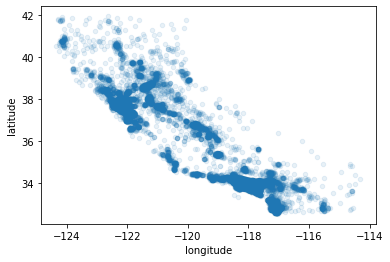

In [16]:
'''
Create a scatterplot for longitude and latitude.
Tune the alpha value to set different density.
'''
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

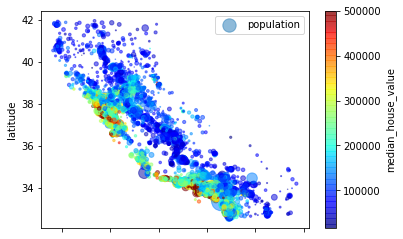

In [17]:
'''
This is a very important plot.
The color change tells about the price changes in different distrcits.
The size of the bubbles tells about the population of the districts.
'''
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5, 
             s=housing["population"]/100, label="population", 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True
            )
plt.legend()
plt.show()

In [18]:
'''
We can plot a box plot of the price distributions.
'''

'\nWe can plot a box plot of the price distributions.\n'

In [19]:
'''Look at the correlation matrix. Sort the matrix values in descending order wrt median_house_value'''
corr_matrix = housing.corr()
corr_matrix = corr_matrix["median_house_value"].sort_values(ascending=False)
print(corr_matrix)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64


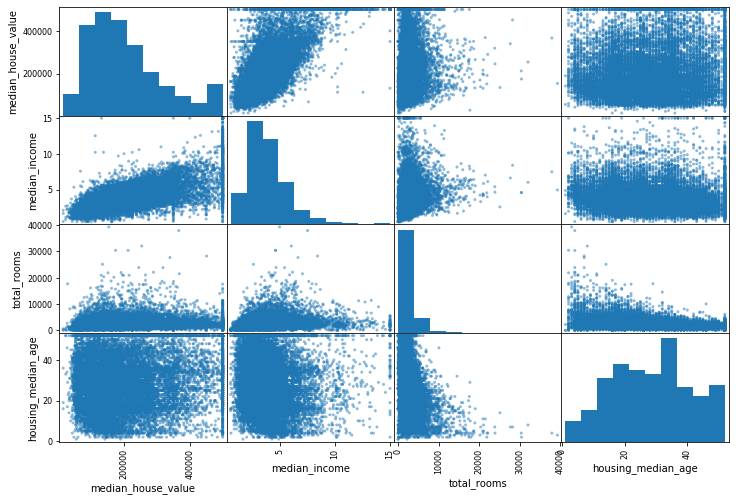

In [20]:
'''Let's plot a multi-variate scatter matrix'''
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

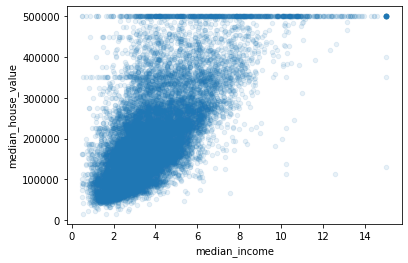

In [21]:
'''plot scatter plot x="median_income", y="median_house_value". It is kind of linear.'''
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

In [22]:
'''Let us find out the correlation with attribute combinations'''
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix = corr_matrix["median_house_value"].sort_values(ascending=False)
print(corr_matrix)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64


# Prepare the Data for Machine Learning Algorithms

In [23]:
'''For data preparation, get a fresh copy of the train set. Separate out the target variable'''
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

print('Train Data: ', housing.shape)
print("Label values: \n", housing_labels)

Train Data:  (16512, 9)
Label values: 
 17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64


In [24]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [25]:
'''
See above, total_bedrooms has missing values.
To handle the missing values. 
There are three ways:
1) Get rid of the corresponding districts.
2) Get rid of the whole attribute.
3) Set the values to some value (zero, the mean, the median, etc.).
We will go with option 3
'''
# housing.dropna(subset=["total_bedrooms"]) # option1
# housing.drop("total_bedrooms", axis=1) # option2
median = housing["total_bedrooms"].median() # option3
housing["total_bedrooms"].fillna(median)

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
          ...  
6563      236.0
12053     294.0
13908     872.0
11159     380.0
15775     682.0
Name: total_bedrooms, Length: 16512, dtype: float64

In [26]:
'''
Another way of handling missing numeric values is using Imputer of Scikit-Learn.
As this can be applied only to numeric values, lets separate the ocean_proximity.
'''
housing_num = housing.drop("ocean_proximity", axis=1)

imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
print("Transformed Data: ", housing_tr.shape)

Transformed Data:  (16512, 8)


In [27]:
'''
Handling categorical and text attributes.
First encode the labels.
'''
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print(housing_cat_encoded)

[0 0 4 ... 1 0 3]


In [28]:
'''
Handling categorical and text attributes
Add a one hot attribute to the encoded feature.
'''
encoder = OneHotEncoder(categories='auto')
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
print(housing_cat_1hot.shape)
'''To convert into ndarray'''
housing_cat_1hot.toarray()

(16512, 5)


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [29]:
'''
We can apply both transformations (from text categories to integer categories, then
from integer categories to one-hot vectors) in one shot using the LabelBinarizer.
This returns a dense NumPy array by default. You can get a sparse matrix
instead by passing sparse_output=True to the LabelBinarizer constructor.
'''
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
print(housing_cat_1hot.shape)

(16512, 5)


In [30]:
'''
Custom Transformer:
In this example the transformer has one hyperparameter, add_bedrooms_per_room ,
set to True by default (it is often helpful to provide sensible defaults). This hyperpara‐
meter will allow you to easily find out whether adding this attribute helps the
Machine Learning algorithms or not. More generally, you can add a hyperparameter
to gate any data preparation step that you are not 100% sure about. The more you
automate these data preparation steps, the more combinations you can automatically
try out, making it much more likely that you will find a great combination (and sav‐
ing you a lot of time).
'''
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [31]:
'''Use the transformer'''
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
print(housing_extra_attribs.shape)

(16512, 11)


In [32]:
'''Create a simple Pipeline for numerical values'''
num_pipeline = Pipeline([
                        ('imputer', SimpleImputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                        ])
housing_num_tr = num_pipeline.fit_transform(housing_num)
print("Transformed Data: ", housing_num_tr.shape)

Transformed Data:  (16512, 11)


In [33]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [34]:
'''
Transformation and Feature Scaling:
All transformation pipelines in one place.
'''
class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values


class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, sparse_output=False):
          self.sparse_output = sparse_output
    
    def fit(self, X, y=None):
        self.enc = LabelBinarizer(sparse_output=self.sparse_output)
        self.enc.fit(X)
        return self
    
    def transform(self, X, y=None):
          return self.enc.transform(X)
        

class CustomBinarizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, sparse_output=False):
          self.sparse_output = sparse_output
    
    def fit(self, X, y=None):
        self.label_binarizer_ = LabelBinarizer(sparse_output=self.sparse_output).fit(X)
        return self
    
    def transform(self, X):
        return self.label_binarizer_.transform(X)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
                        ('selector', DataFrameSelector(num_attribs)),
                        ('imputer', SimpleImputer(strategy="median")),
                        ('attribs_adder', CombinedAttributesAdder()),
                        ('std_scaler', StandardScaler()),
                        ])

cat_pipeline = Pipeline([
                        ('selector', DataFrameSelector(cat_attribs)),
                        ('label_binarizer', CustomBinarizer()),
                        ])

full_pipeline = FeatureUnion(transformer_list=[
                            ("num_pipeline", num_pipeline),
                            ("cat_pipeline", cat_pipeline),
                            ])

In [35]:
'''Transform the data using pipeline'''
print("Raw Data: ", housing.shape)
housing_prepared = full_pipeline.fit_transform(housing)
print("Prepared Data: ", housing_prepared.shape)

Raw Data:  (16512, 9)
Prepared Data:  (16512, 16)


# Training model and Evaluation on the Training Set

In [36]:
'''Model Linear Regression'''
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
some_data = housing.iloc[:10000]
some_labels = housing_labels.iloc[:10000]
some_data_prepared = full_pipeline.fit_transform(some_data)
print("Test Set:", some_data.shape)
print("Prepared Test Set:", some_data_prepared.shape)

Test Set: (10000, 9)
Prepared Test Set: (10000, 16)


In [38]:
'''Predict on the prepared test data'''
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210664.29097266 317929.12408419 211108.79574709 ... 268101.74948831
  68461.18127728 219146.19351711]


In [39]:
'''Calculate RMSE on the predictions'''
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Linear Regression RMSE:", lin_rmse)

Linear Regression RMSE: 68628.19819848922


In [40]:
'''Model: DecisionTreeRegressor'''
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Decision Tree Regressor Regression RMSE:", tree_rmse)

Decision Tree Regressor Regression RMSE: 0.0


In [41]:
'''Better Evaluation Using Cross-Validation: Linear Regression'''
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


In [50]:
'''Better Evaluation Using Cross-Validation: Decision Tree Regressor'''
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [70711.63668812 67088.2551087  69689.17341056 68997.0233018
 70473.32050764 76191.57903266 69304.38224574 71177.49637934
 76248.05512377 69629.61546388]
Mean: 70951.05372622238
Standard deviation: 2839.853361539381


In [51]:
'''Better Evaluation Using Cross-Validation: Random Forest Regressor'''
forest_reg = RandomForestRegressor(n_estimators=100)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49809.6272195  47648.96587552 49993.52932373 52228.49772392
 49687.42008545 53597.95119001 49114.69979545 47507.51022401
 52970.38579793 50093.78262062]
Mean: 50265.23698561387
Standard deviation: 1967.1692431648864


In [52]:
'''Save the model object'''
joblib.dump(forest_reg, "housing_rf_reg.pkl")
'''Reload the model object'''
housing_rf_reg = joblib.load("housing_rf_reg.pkl")
'''Predict Again'''
forest_scores = cross_val_score(housing_rf_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49805.76897712 47580.09485225 50159.62731513 52378.6935324
 49804.53788839 53546.73438352 48915.56288453 47453.50739778
 53142.05468836 50396.1073912 ]
Mean: 50318.268931067374
Standard deviation: 2021.681148827329


In [53]:
'''Better Evaluation Using Cross-Validation: SVM Regressor'''
svm_reg=SVR(kernel='linear', degree=1)
svr_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [105342.09141998 112489.24624123 110092.35042753 113403.22892482
 110638.90119657 115675.8320024  110703.56887243 114476.89008206
 113756.17971227 111520.1120808 ]
Mean: 111809.84009600841
Standard deviation: 2762.393664321567


In [54]:
'''Save the model object'''
joblib.dump(svm_reg, "housing_svm_reg.pkl")
'''Reload the model object'''
housing_svm_reg = joblib.load("housing_svm_reg.pkl")
'''Predict Again'''
svr_scores = cross_val_score(housing_svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

Scores: [105342.09141998 112489.24624123 110092.35042753 113403.22892482
 110638.90119657 115675.8320024  110703.56887243 114476.89008206
 113756.17971227 111520.1120808 ]
Mean: 111809.84009600841
Standard deviation: 2762.393664321567


# Fine-tune the model

In [57]:
'''
One way to do that would be to fiddle with the hyperparameters manually, until you
find a great combination of hyperparameter values. This would be very tedious work,
and you may not have time to explore many combinations.
Instead you should get Scikit-Learn’s GridSearchCV to search for you. All you need to
do is tell it which hyperparameters you want it to experiment with, and what values to
try out, and it will evaluate all the possible combinations of hyperparameter values,
using cross-validation. For example, the following code searches for the best combi‐
nation of hyperparameter values for the RandomForestRegressor.
'''
start_time = datetime.datetime.now()
print("Grid Search started at", start_time)
param_grid = [
            {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
            {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
            ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)
print(grid_search.best_params_)
end_time = datetime.datetime.now()
time_taken = end_time - start_time
print("Grid Search completed at", end_time, "Search Time:", time_taken)

Grid Search started at 2019-09-15 11:45:22.288435
{'max_features': 8, 'n_estimators': 30}
Grid Search completed at 2019-09-15 11:46:11.484995 Search Time: 0:00:49.196560


In [58]:
'''Analyze the Best Models and Their Errors'''
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3547346276575537, 'median_income'),
 (0.16042068253356076, 'INLAND'),
 (0.11490052488568314, 'pop_per_hhold'),
 (0.07188719947456564, 'bedrooms_per_room'),
 (0.07005549233720627, 'longitude'),
 (0.06630351496929088, 'latitude'),
 (0.05064521165065951, 'rooms_per_hhold'),
 (0.04323905384355372, 'housing_median_age'),
 (0.015671482528160526, 'population'),
 (0.014784963121819273, 'households'),
 (0.014556746047414028, 'total_bedrooms'),
 (0.014495152543208902, 'total_rooms'),
 (0.003337081826666695, 'NEAR OCEAN'),
 (0.0032511799589919153, '<1H OCEAN'),
 (0.0016708785282483652, 'NEAR BAY'),
 (4.620809341667626e-05, 'ISLAND')]

# Evaluate the model on Test Set

In [61]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

51488.80028052732
